## Imports

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix
import math

## Utilities

In [2]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    # Check if there are more than two series to plot
    if type(y) is tuple:
      # Loop over the y elements
      for y_curr in y:
        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)
    # Label the x-axis
    plt.xlabel(xlabel)
    # Label the y-axis
    plt.ylabel(ylabel)
    # Set the legend
    if legend:
      plt.legend(legend)
    plt.title(title)
    # Overlay a grid on the graph
    plt.grid(True)
    # Draw the graph on screen
    plt.show()



## Read Data

In [3]:
datasets = ["AAPL.csv","GOOG.csv","NFLX.csv","MSFT.csv"]

In [4]:
data =  pd.read_csv(datasets[0])


## Split the Dataset

In [5]:
# Define the split size
split_size = int(len(data) * 0.8)

# Get the train set 
time_train = data["Date"][:split_size]
x_train = data["Adj Close"][:split_size]

# Get the validation set
time_test = data["Date"][split_size:]
x_test = data["Adj Close"][split_size:]

## Prepare Features and Labels

In [6]:
# Parameters
window_size = 20
batch_size = 16
shuffle_buffer_size = 1000

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  # Create tuples with features and labels 
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [8]:
# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2024-04-10 16:19:17.774253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Build the Model

In [9]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 20, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


## Tune the Learning Rate

In [10]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
62/62 [==============================] - 5s 16ms/step - loss: 51.2033 - lr: 1.0000e-08
Epoch 2/100
62/62 [==============================] - 1s 10ms/step - loss: 42.7931 - lr: 1.1220e-08
Epoch 3/100
62/62 [==============================] - 1s 10ms/step - loss: 37.1909 - lr: 1.2589e-08
Epoch 4/100
62/62 [==============================] - 1s 11ms/step - loss: 31.0084 - lr: 1.4125e-08
Epoch 5/100
62/62 [==============================] - 1s 11ms/step - loss: 25.1591 - lr: 1.5849e-08
Epoch 6/100
62/62 [==============================] - 1s 11ms/step - loss: 19.0383 - lr: 1.7783e-08
Epoch 7/100
62/62 [==============================] - 1s 11ms/step - loss: 12.8688 - lr: 1.9953e-08
Epoch 8/100
62/62 [==============================] - 1s 11ms/step - loss: 7.2102 - lr: 2.2387e-08
Epoch 9/100
62/62 [==============================] - 1s 11ms/step - loss: 5.3425 - lr: 2.5119e-08
Epoch 10/100
62/62 [==============================] - 1s 11ms/step - loss: 5.1804 - lr: 2.8184e-08
Epoch 11/100

(1e-08, 0.001, 0.0, 50.0)

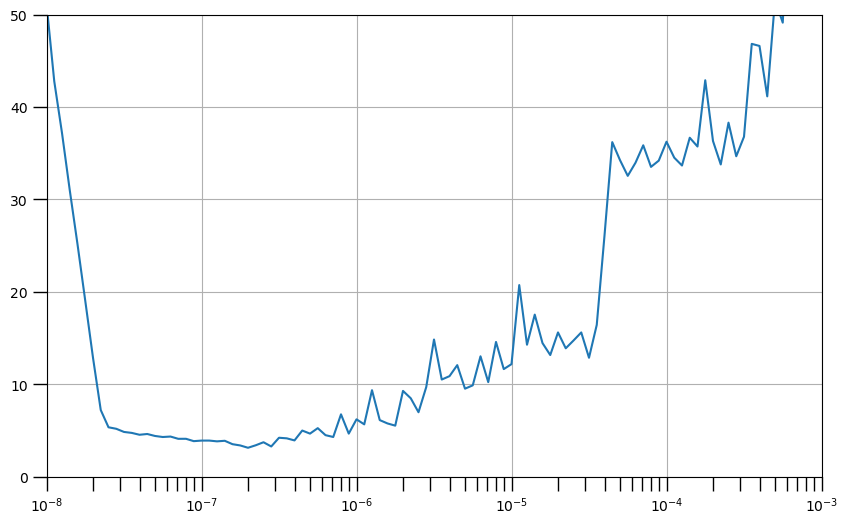

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

In [22]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [24]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check the validation set MAE
    if(logs.get('mae') < 3.2):
      # Stop if threshold is met
      print("\nRequired MAE is met.")
      self.model.stop_training = True

# Instantiate the class
callbacks = myCallback()

In [25]:
# Set the learning rate
learning_rate = 1e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set, epochs=500, callbacks=[callbacks])

Epoch 1/500
62/62 [==============================] - 4s 12ms/step - loss: 3.8587 - mae: 4.3387
Epoch 2/500
60/62 [============================>.] - ETA: 0s - loss: 2.6981 - mae: 3.1593
Required MAE is met.
62/62 [==============================] - 1s 11ms/step - loss: 2.6989 - mae: 3.1610


## Model Prediction

In [15]:
def model_forecast(model, series, window_size, batch_size):
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

62/62 [==============================] - 0s 4ms/step


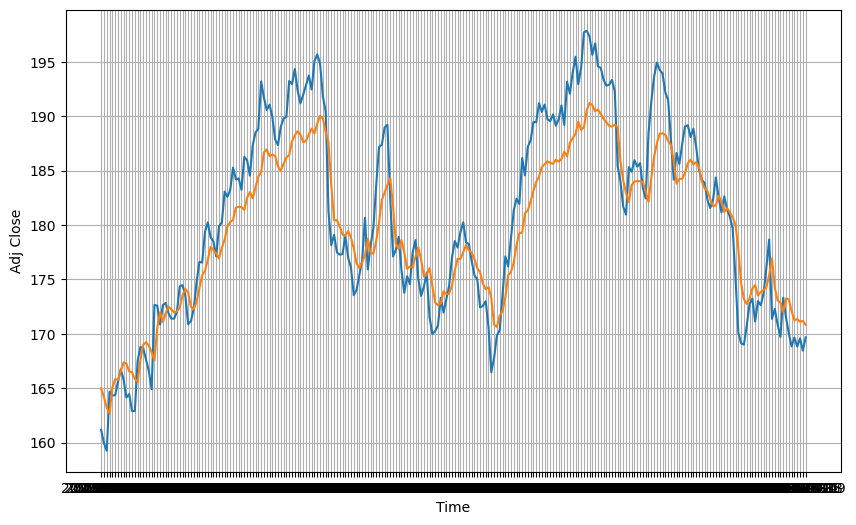

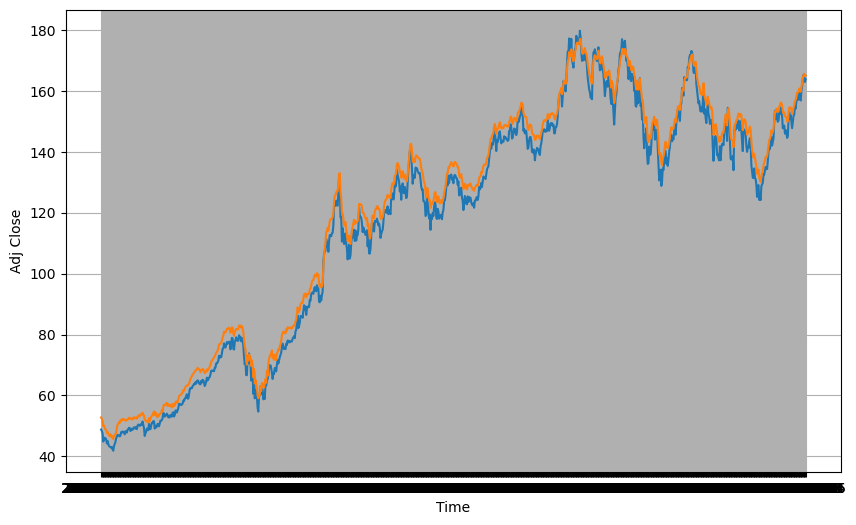

In [26]:
# Reduce the original series
forecast_series = data["Adj Close"][split_size-window_size:-1]
forecast_train = x_train

# Generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)
forecast2 = model_forecast(model, forecast_train, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
results2 = forecast2.squeeze()

# Plot the results
plot_series(time_test, (x_test, results),xlabel="Time",ylabel="Adj Close")
plot_series(time_train[window_size-1:], (x_train[window_size-1:], results2),xlabel="Time",ylabel="Adj Close")

Compute the metrics

In [32]:
# Compute the MSE and MAE
print(math.sqrt(tf.keras.metrics.mean_squared_error(x_test, results).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_test, results).numpy())

3.5580721995344065
2.9620192


## Make Classification

In [34]:
def create_labels(prices, threshold=0.005):
    labels = []
    for i in range(1, len(prices)):
        pct_change = (prices.iloc[i] - prices.iloc[i-1]) 
        if pct_change > threshold:
            labels.append(2)  # 'Artar' sınıfı
        elif pct_change < -threshold:
            labels.append(0)  # 'Azalır' sınıfı
        else:
            labels.append(1)  # 'Değişmez' sınıfı
    return labels

In [35]:
x_test_labels = create_labels(x_test)
x_test_preds_abels = create_labels(pd.Series(results))

In [36]:
print("Accuracy: " ,accuracy_score(x_test_labels,x_test_preds_abels))
print("Confusion Matrix: ", confusion_matrix(x_test_labels,x_test_preds_abels))

Accuracy:  0.5258964143426295
Confusion Matrix:  [[63  0 61]
 [ 1  0  0]
 [56  1 69]]
